based on: https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#609f

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss

from sklearn import metrics

import seaborn as sns
sns.set_style("whitegrid")

# Data gen

In [128]:
N_exp = 2000

N_0 = 1000
N_1 = 1000

uplift = 0.2

sigma = 1.75 # views variance
beta = 500 # user ctr variance


ctr_0 = 0.02
ctr_1 = ctr_0 * (1 + uplift)


alpha_0 = beta * ctr_0 / (1 - ctr_0)
alpha_1 = beta * ctr_1 / (1 - ctr_1)



n_views_0 = np.ceil(ss.lognorm.rvs(sigma, size=N_0*N_exp)).astype(int)
n_views_1 = np.ceil(ss.lognorm.rvs(sigma, size=N_1*N_exp)).astype(int)

ctrs_0 = ss.beta.rvs(alpha_0, beta, size=N_0*N_exp)
ctrs_1 = ss.beta.rvs(alpha_1, beta, size=N_1*N_exp)

clicks_0 = ss.binom.rvs(n_views_0, ctrs_0)
clicks_1 = ss.binom.rvs(n_views_1, ctrs_1)

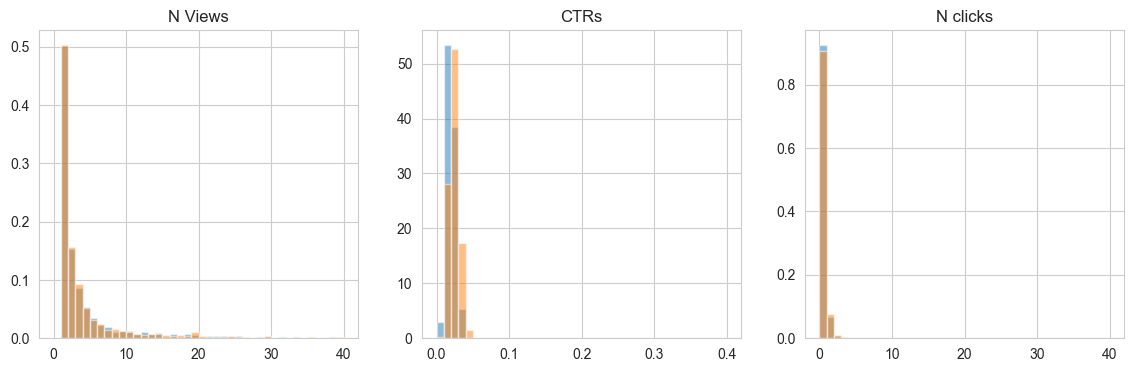

In [129]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 4))

ax1.set_title('N Views')
ax1.hist(n_views_0[:N_0], bins=40, range=(0, 40), alpha=0.5, density=True);
ax1.hist(n_views_1[:N_1], bins=40, range=(0, 40), alpha=0.5, density=True);

ax2.set_title('CTRs')
ax2.hist(ctrs_0[:N_0], bins=40, alpha=.5, density=True, range=(0,.4));
ax2.hist(ctrs_1[:N_1], bins=40, alpha=.5, density=True, range=(0,.4));

ax3.set_title('N clicks')
ax3.hist(clicks_0[:N_0], bins=40, alpha=.5, density=True, range=(0,40));
ax3.hist(clicks_1[:N_1], bins=40, alpha=.5, density=True, range=(0,40));

In [130]:
n_views_0 = n_views_0.reshape((N_exp, -1))
n_views_1 = n_views_1.reshape((N_exp, -1))

ctrs_0 = ctrs_0.reshape((N_exp, -1))
ctrs_1 = ctrs_1.reshape((N_exp, -1))

clicks_0 = clicks_0.reshape((N_exp, -1))
clicks_1 = clicks_1.reshape((N_exp, -1))

# Tests

## T-test

In [131]:
p_vals = ss.ttest_ind(clicks_1, clicks_0, axis=1, alternative='greater', equal_var=True).pvalue
print(f"Power: {(p_vals<.05).mean():.4f}")

Power: 0.2270


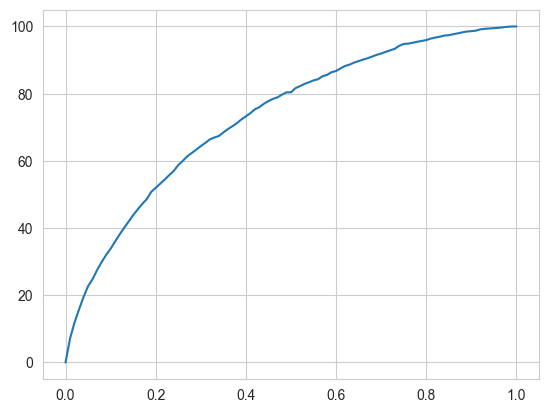

In [132]:
densities, thr = np.histogram(p_vals, bins=100, density=True, range=(0,1))

plt.plot(thr, np.r_[0,np.cumsum(densities)])

## MannWhitney

In [133]:
p_vals = ss.mannwhitneyu(clicks_1, clicks_0, axis=1, alternative='greater').pvalue
print(f"Power: {(p_vals<.05).mean():.4f}")

Power: 0.2570


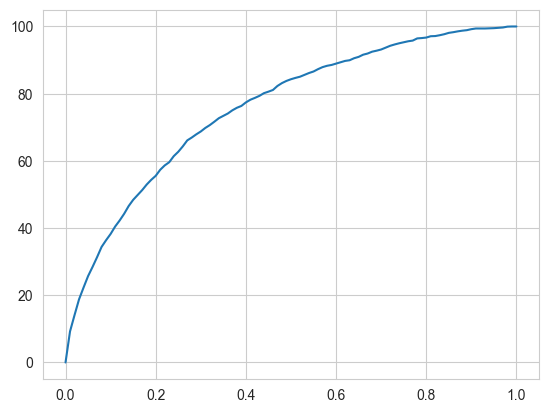

In [134]:
densities, thr = np.histogram(p_vals, bins=100, density=True, range=(0,1))

plt.plot(thr, np.r_[0,np.cumsum(densities)])

## Standard bootstrap

In [135]:
import tqdm

In [136]:
p_vals = []
for exp in tqdm.tqdm(range(clicks_0.shape[0])):
    c0 = clicks_0[exp, :]
    c1 = clicks_1[exp, :]
    n0 = len(c0)
    n1 = len(c1)

    N_straps = 1000
    pool = np.r_[c0, c1]
    difs = []
    for i in range(N_straps):
        resample = np.random.choice(pool, size=n0+n1)
        a, b = resample[:n0], resample[n0:]
        difs.append(b.mean() - a.mean())
    p_vals.append((difs > (c1.mean() - c0.mean())).mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 51.15it/s]


In [137]:
p_vals = np.asarray(p_vals)
print(f"Power: {(p_vals<.05).mean():.4f}")

Power: 0.2295


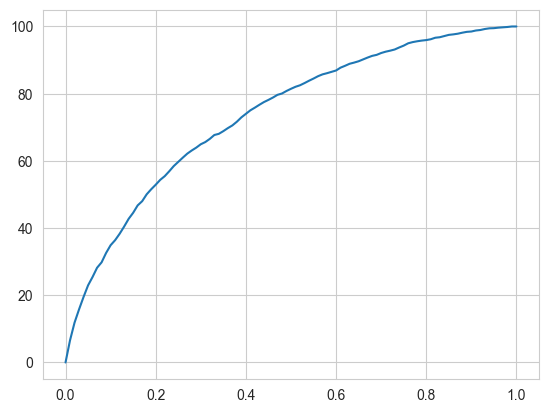

In [138]:
densities, thr = np.histogram(p_vals, bins=100, density=True, range=(0,1))

plt.plot(thr, np.r_[0,np.cumsum(densities)])

In [145]:
alphas = thr
pwrs = np.r_[0, np.cumsum(densities)] / 100
bayes_factors = pwrs / alphas

/var/folders/x1/7tpmxff13rbg540ss_n2v2g80000gn/T/ipykernel_4763/3494435277.py:3: RuntimeWarning: invalid value encountered in divide
  bayes_factors = pwrs / alphas


(0.0, 1.0495)

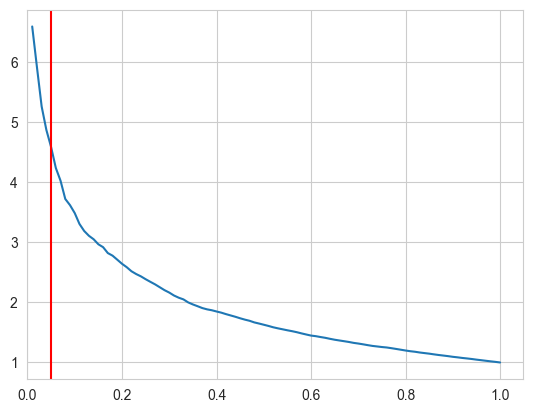

In [151]:
plt.plot(thr, bayes_factors)
plt.axvline(.05,color='r')
plt.xlim(left=0)

## Poisson bootstrap